# Cortical network model

Analysis of 3-population cortical network model with a focus on the effect of the synaptic strength on the network dynamics evoked by a stimulus

## Imports

In [1]:
%load_ext autoreload
%load_ext usnm2p.skip_kernel_extension
%autoreload 2

In [2]:
# External imports
import datetime
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import jupyter_slack

# Internal modules
from usnm2p.logger import logger
from usnm2p.network_model import *
from usnm2p.model_optimizer import *
from usnm2p.utils import *
from usnm2p.fileops import get_data_root, load_lineagg_data, save_figs_book
from usnm2p.constants import *
from usnm2p.batchutils import *
from usnm2p.plotters import plot_table, harmonize_axes_limits
from usnm2p.postpro import get_fit_table, get_change_key, get_propagg_keys, compute_predictor, bin_by_quantile_intervals, free_expand
from usnm2p.model_params import *

# Initialize empty figures dictionary
figs = {}

# Set up logging folder
logdir = get_data_root(kind=DataRoot.MODEL)

### Input data parameters

In [3]:
# Parameters determining location of reference activity profiles
analysis_type = 'main' # DEFAULT_ANALYSIS  # Analysis type
layer = None  # cortical layer
global_correction = GLOBAL_CORRECTION  # global stack correction method
kalman_gain = KALMAN_GAIN  # Gain of Kalman filter
gcamp_key = get_gcamp_key(None)  # GCaMP key
neuropil_scaling_coeff = NEUROPIL_SCALING_COEFF  # scaling coefficient for neuropil subtraction
baseline_quantile = BASELINE_QUANTILE  # evaluation quantile for baseline computation
baseline_wquantile = BASELINE_WQUANTILE  # quantile filter window size (s) to compute fluorescence baseline
baseline_wsmoothing = BASELINE_WSMOOTHING  # gaussian filter window size (s) to smooth out fluorescence baseline
trial_aggfunc = TRIAL_AGGFUNC  # trial aggregation function
ykey_classification = YKEY_CLASSIFICATION  # Reference variable for response classification
directional = DIRECTIONAL_DETECTION  # whether to look for directional (i.e. positive only) effect for response detection
errprop = 'inter'

# Processing parameters
slack_notify = False   # notify start and completion on slack
run_state_dep = False  # Whether to run state-dependency analysis

### Derived parameters

 2025/09/17 15:09:58: circuit model analysis notebook started on 2025-09-17 at 15:09:58
 2025/09/17 15:09:58: assembling batch analysis settings...


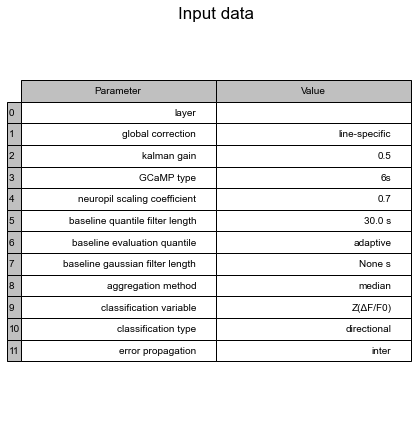

In [4]:
skip_state_dep = not run_state_dep  # Whether to skip state-dependency analysis

# Get time stamp from notebook start
tstamp_start = datetime.datetime.now()
fmts = ['%Y-%m-%d', '%H:%M:%S']
# Log start process
s = f'circuit model analysis notebook started on {tstamp_start.strftime(fmts[0])} at {tstamp_start.strftime(fmts[1])}'
if slack_notify:
    jupyter_slack.notify_self(s)
logger.info(s)

# Get data input directory
_, input_dir, figsdir, _ = get_batch_settings(
    analysis_type, None, layer, global_correction, kalman_gain, neuropil_scaling_coeff,
    baseline_quantile, baseline_wquantile, baseline_wsmoothing,
    trial_aggfunc, ykey_classification, directional)
baseline_quantile_str = 'adaptive' if baseline_quantile is None else f'{baseline_quantile:.2f}'

# Plot dataset info table
figs['dataset_info'] = plot_table({
    'layer': layer,
    'global correction': 'line-specific' if isinstance(global_correction, dict) else global_correction,
    'kalman gain': kalman_gain,
    'GCaMP type': gcamp_key,
    'neuropil scaling coefficient': neuropil_scaling_coeff,
    'baseline quantile filter length': f'{baseline_wquantile} s',
    'baseline evaluation quantile': baseline_quantile_str,
    'baseline gaussian filter length': f'{baseline_wsmoothing} s',
    'aggregation method': trial_aggfunc.__name__,
    'classification variable': ykey_classification,
    'classification type': f"{'' if directional else 'non '}directional",
    'error propagation': errprop,
    }, title='Input data', aspect=1.5)

### Load data and compute raw response profiles

 2025/09/17 15:09:59: loading line-average data (with inter-propagated SE)
 2025/09/17 15:09:59: loading line3 data from /Users/tlemaire/Documents/data/usnm/lineagg/aggmedian_classzscore_directional/alpha0.7_qadaptive_wq30.0s/suite2p_fs_3.56_reg_tif_tau_1.25/kd_G0.5_V0.05_npad10/submap_0<-1_stim-1->stimeverytrial/main folder
 2025/09/17 15:09:59: loading sst data from /Users/tlemaire/Documents/data/usnm/lineagg/aggmedian_classzscore_directional/alpha0.7_qadaptive_wq30.0s/suite2p_fs_3.56_reg_tif_tau_1.25/kd_G0.5_V0.05_npad10/submap_0<-1_stim-1->stimeverytrial/main folder
 2025/09/17 15:09:59: loading pv data from /Users/tlemaire/Documents/data/usnm/lineagg/aggmedian_classzscore_directional/alpha0.7_qadaptive_wq30.0s/suite2p_fs_3.56_reg_tif_tau_1.25/kd_G0.5_V0.05_npad10/linreg_robust/submap_0<-1_stim-1->stimeverytrial/main folder
 2025/09/17 15:09:59: loading sarah_line3 data from /Users/tlemaire/Documents/data/usnm/lineagg/aggmedian_classzscore_directional/alpha0.7_qadaptive_wq30.0s/sui

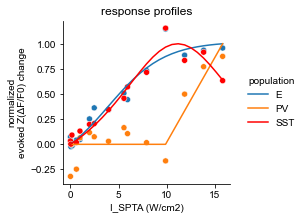

In [5]:
# Load line-aggregated stats
stats, counts = load_lineagg_data(input_dir, errprop=errprop)

# Restrict to 'all' responses
isall = stats.index.get_level_values(Label.ROI_RESP_TYPE) == 'all'
stats = (
    stats[isall]
    .droplevel(Label.ROI_RESP_TYPE)
    .reset_index(Label.RUN, drop=True)
)

# Extract data for responses of interest
xkey = Label.ISPTA
ykey = Label.ZSCORE
ykey_diff = get_change_key(ykey)
ykey_diff_prop = get_propagg_keys(ykey_diff)[0]
resp_data = (
    stats[[Label.ISPTA, ykey_diff_prop]]
    .rename(columns={ykey_diff_prop: ykey_diff})
    .set_index(Label.ISPTA, append=True)
    [ykey_diff]
)

# Fit response data
fit_dict = get_fit_table().loc[xkey]
predictors = {}
for pop, resp in resp_data.groupby(Label.LINE):
    predictors[pop] = compute_predictor(
        resp.droplevel(Label.LINE).index.values, 
        resp.values, 
        fit_dict.loc[pop])

# Compute fit profiles over dense input range
xbounds = np.sort(resp_data.index.unique(xkey))[[0, -1]]
xdense = np.linspace(*xbounds, 25).round(3)
resp_profiles = pd.DataFrame(index=pd.Index(xdense, name=xkey))
for pop, pred in predictors.items():
    resp_profiles[pop] = pred(xdense)
resp_profiles = (
    resp_profiles
    .stack()
    .rename_axis(index={None: Label.LINE})
    .swaplevel()
    .sort_index()
    .rename(ykey_diff)
)

# Apply lines->populations mapping
newobjs = []
for s in resp_profiles, resp_data:
    s = s.reset_index(level=Label.LINE)
    s[Label.LINE] = s[Label.LINE].str.replace('line3', 'e').str.upper()
    s['population'] = s.pop(Label.LINE)
    s = s.set_index('population', append=True).swaplevel().sort_index()[ykey_diff]
    newobjs.append(s)
resp_profiles, resp_data = newobjs

# Normalize response data
logger.info('normalizing predictors to [0, 1] range')
resp_bounds = resp_profiles.abs().groupby('population').agg(['min', 'max'])#.droplevel(0, axis=0)
resp_ranges = resp_bounds.diff(axis=1).iloc[:, 1].rename('range')
ykey_diff = f'normalized\n{ykey_diff}'
resp_data = ((resp_data - resp_bounds['min']) / resp_ranges).rename(ykey_diff)
resp_profiles = ((resp_profiles - resp_bounds['min']) / resp_ranges).rename(ykey_diff)

# Plot response profiles
figs['resp_profiles'], ax = plt.subplots(figsize=(3, 3))
sns.despine(ax=ax)
pltkwargs = dict(
    ax=ax,
    x=xkey, 
    y=ykey_diff,
    hue='population',
    palette=NetworkModel.palette,
)
sns.scatterplot(data=resp_data.reset_index(), legend=False, **pltkwargs)
sns.lineplot(data=resp_profiles.reset_index(), **pltkwargs)
sns.move_legend(ax, loc='center left', bbox_to_anchor=(1.05, 0.5), frameon=False)
ax.set_title('response profiles')

# Save response profiles to file (if not already saved)
ref_profiles = resp_profiles.unstack('population').round(3)
logger.info('saving reference profiles to CSV file')
ref_fpath = os.path.join(logdir, 'ref_profiles.csv')
if not os.path.exists(ref_fpath):
    ref_profiles.to_csv(ref_fpath)

# Extract input amplitudes from reference profiles
amps = ref_profiles.index.values

## Literature review

 2025/09/17 15:10:00: initialized NetworkModel(E, PV, SST, VIP)
 2025/09/17 15:10:00: initialized NetworkModel(E, PV, SST, VIP)
 2025/09/17 15:10:00: initialized NetworkModel(E, PV, SST, VIP)
 2025/09/17 15:10:00: initialized NetworkModel(E, PV, SST, VIP)


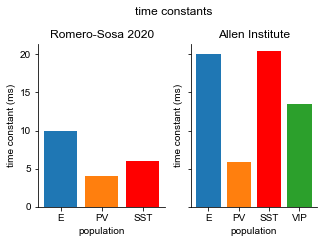

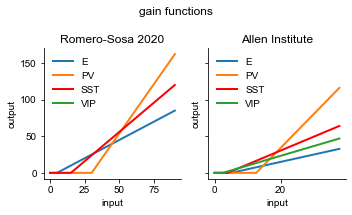

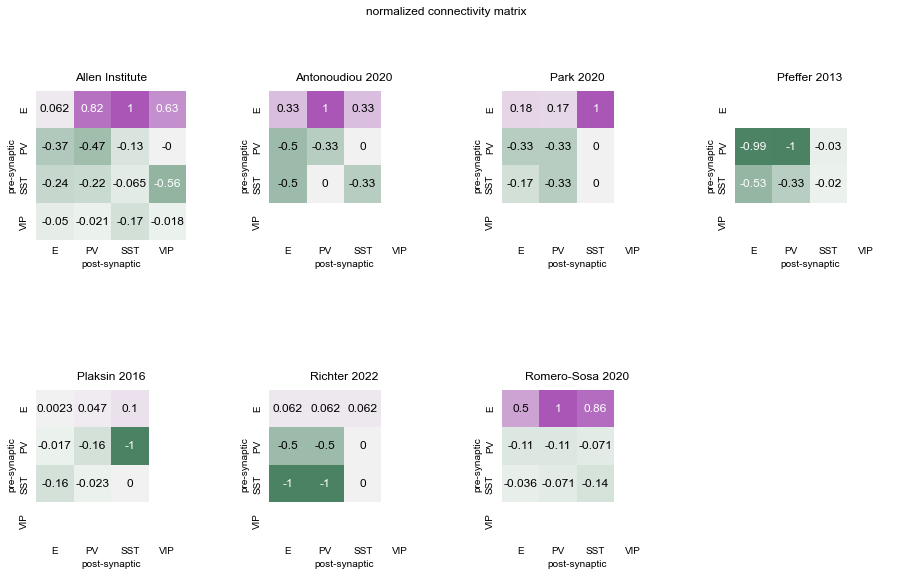

In [6]:
# Firing rate adaptation time constants 
figs['litreview tau'], axes = plt.subplots(
    1, len(tau_dict), figsize=(2.5 * len(tau_dict), 3), sharey=True)
figs['litreview tau'].suptitle('time constants', y=1.05)
for ax, (key, t) in zip(axes, tau_dict.items()):
    NetworkModel(tau=t).plot_time_constants(ax=ax)
    ax.set_title(key)

# Gain function parameters
figs['litreview fgains'], axes = plt.subplots(
    1, len(fparams_dict), figsize=(2.5 * len(fparams_dict), 3), sharey=True)
figs['litreview fgains'].suptitle('gain functions')
for ax, (key, fp) in zip(axes, fparams_dict.items()):
    NetworkModel(fparams=fp).plot_fgain(ax=ax)
    ax.set_title(key)

# Connectivity matrices
figs['litreview W'] = NetworkModel.plot_connectivity_matrix(W_dict, norm=True)

## Initialize models

In [7]:
# Initialize 4-population model from defined source
source_key = 'Allen Institute'
model4 = NetworkModel(
    W=W_dict[source_key].copy(),
    tau=tau_dict[source_key].copy(), 
    fparams=fparams_dict[source_key].copy(),
)

# Create 3 population variant without VIP population
model3 = model4.copy()
model3.remove_population('VIP')

 2025/09/17 15:10:02: initialized NetworkModel(E, PV, SST, VIP)
 2025/09/17 15:10:02: initialized NetworkModel(E, PV, SST, VIP)
 2025/09/17 15:10:02: NetworkModel(E, PV, SST, VIP): removing VIP population
 2025/09/17 15:10:02: resulting model: NetworkModel(E, PV, SST)


### Plot parameters

In [8]:
avg_across_runs = True  # whether to average results across runs or to show each individual run
norm_params = True # False  # whether to normalize model parameters
norm_res = [None, 'style']  # whether/how to normalize output profiles
amps_plt = np.linspace(  # characteristic amplitudes at which to plot timeseries
    amps.min() + 0.15 * np.ptp(amps), amps.max() - 0.15 * np.ptp(amps), 3)

## 3-population (E, SST, PV) model

### Plot model summary

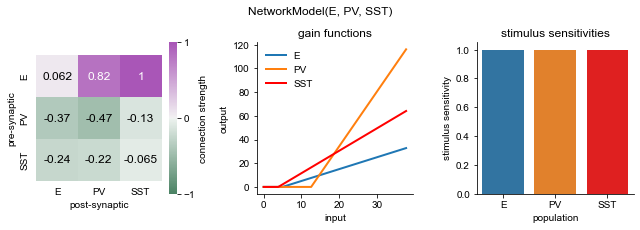

In [9]:
figs['model3'] = model3.plot_summary(norm=norm_params)

### Optimize model parameters and plot resulting predictions for different sets of constraints

 2025/09/17 15:10:03: initialized ModelOptimizer([E, PV, SST], diffev, norm, xwdev=2.0)
 2025/09/17 15:10:03: ModelOptimizer([E, PV, SST], diffev, norm, xwdev=2.0), relwmax = 0.3, uniform srel
 2025/09/17 15:10:03: found 5 optimization log files in /Users/tlemaire/Documents/data/usnm/model
 2025/09/17 15:10:03: ModelOptimizer([E, PV, SST], diffev, norm, xwdev=2.0): running 5 optimization runs
 2025/09/17 15:10:03: loading optimization results from /Users/tlemaire/Documents/data/usnm/model/E-PV-SST_threshold_linear_fparamsa785dfdaf5301479e7da0fdfd76ee39f_tauE20.01PV5.93SST20.36_targetsf2821bbe470def2e47e4849c9edad8f4_wbounds28db625386a7645bd9b236ffe2408f3e_srelbounds0.0-5.0_diffev_norm_xwdev2_unisrel_run0.h5
 2025/09/17 15:10:03: loading optimization results from /Users/tlemaire/Documents/data/usnm/model/E-PV-SST_threshold_linear_fparamsa785dfdaf5301479e7da0fdfd76ee39f_tauE20.01PV5.93SST20.36_targetsf2821bbe470def2e47e4849c9edad8f4_wbounds28db625386a7645bd9b236ffe2408f3e_srelbounds0.0-5

/Users/tlemaire/Documents/code/usnm2p/usnm2p/model_optimizer.py:950: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.stripplot(


0.2816449919923742
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

E vs. PV: Mann-Whitney-Wilcoxon test two-sided, P_val:1.000e+00 U_stat=1.250e+01
PV vs. SST: Mann-Whitney-Wilcoxon test two-sided, P_val:1.000e+00 U_stat=1.250e+01
E vs. SST: Mann-Whitney-Wilcoxon test two-sided, P_val:1.000e+00 U_stat=1.250e+01
 2025/09/17 15:10:06: intrinsic response thresholds (in stimulus units):
                mean       sem
population                    
E           1.191852  0.059323
PV          3.001083  0.149374
SST         0.924877  0.046034
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

E vs. PV: Mann-Whitney-Wilcoxon test two-sided, P_val:7.937e-03 U_stat=0.000e+00
PV vs. SST: Mann-Whitney-Wilcoxon test two

/Users/tlemaire/Documents/code/usnm2p/usnm2p/model_optimizer.py:950: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.stripplot(


0.2996004371004525
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

E vs. PV: Mann-Whitney-Wilcoxon test two-sided, P_val:1.587e-02 U_stat=2.400e+01
PV vs. SST: Mann-Whitney-Wilcoxon test two-sided, P_val:7.937e-03 U_stat=2.500e+01
E vs. SST: Mann-Whitney-Wilcoxon test two-sided, P_val:7.937e-03 U_stat=2.500e+01
 2025/09/17 15:10:09: intrinsic response thresholds (in stimulus units):
                 mean       sem
population                     
E            1.227075  0.064986
PV           4.176674  0.268610
SST         14.687171  4.732569
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

E vs. PV: Mann-Whitney-Wilcoxon test two-sided, P_val:7.937e-03 U_stat=0.000e+00
PV vs. SST: Mann-Whitney-Wilcoxon tes

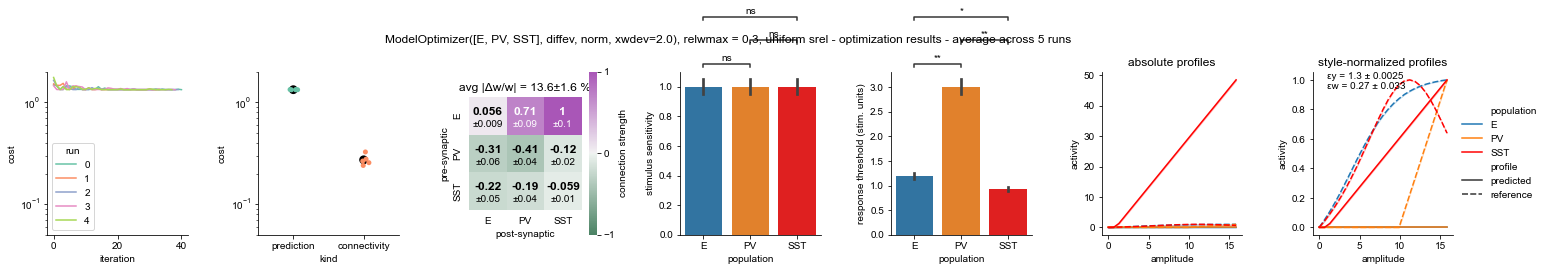

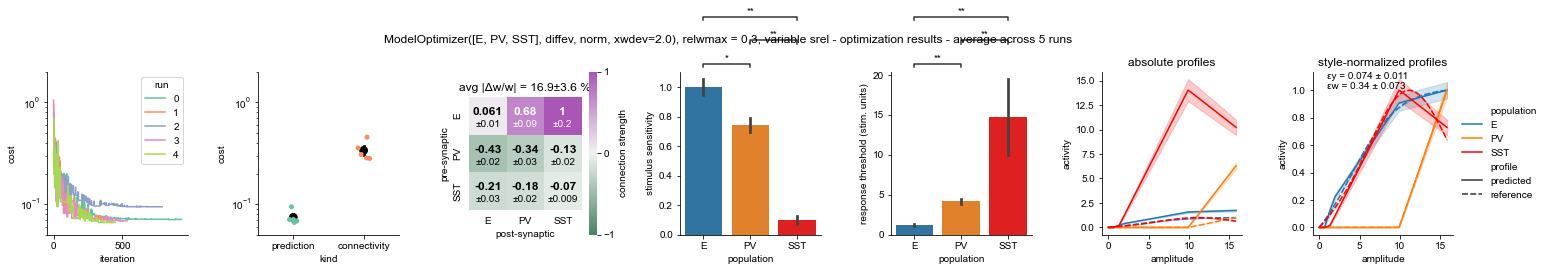

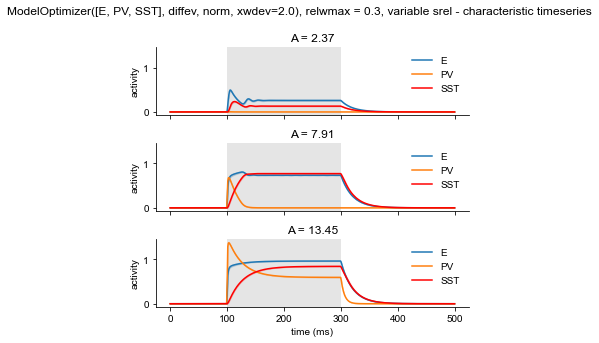

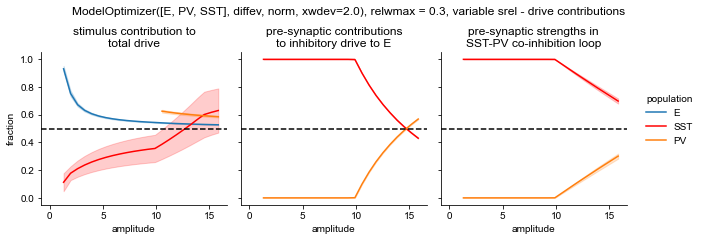

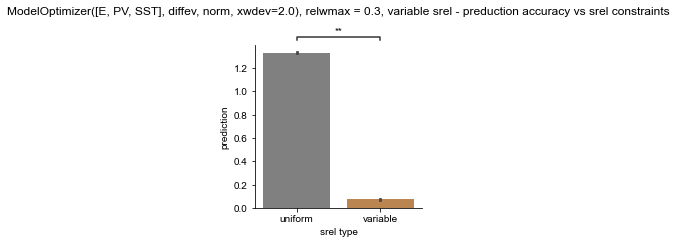

In [10]:
# Construct model optimizer object
optimizer = ModelOptimizer(model3, ref_profiles)

# Define connectivity matrix exploration bounds 
Wbounds, Wkey = optimizer.model.get_coupling_bounds(relwmax=RELWMAX, return_key=True)

# Define stimulus sensitivity search bounds
srel_bounds = (0, SRELMAX)

# Define different sets of stimulus sensitivities constraints
srel_dists = {
    'uniform': True,
    'variable': False,
}

# For each constraint
costs_vs_srel = {}
for srel_key, uniform_srel in srel_dists.items():
    # Construct descriptor string
    desc = f'{optimizer}, {Wkey}, {srel_key} srel'
    logger.info(desc)

    # Optimize model parameters to minimize divergence with reference profiles
    optparams = optimizer.optimize(
        logdir=logdir, 
        Wbounds=Wbounds,
        srel_bounds=srel_bounds,
        uniform_srel=uniform_srel,
        nruns='auto'
    )

    # Plot optimization history
    opt_history = optimizer.load_optimization_histories(
        logdir, Wbounds, srel_bounds, uniform_srel)

    # Plot optimized model parameters and simulated sweep results, compared to reference profiles
    title = f'{desc} - optimization results'
    figs[title], costs = optimizer.plot_results(
        mparams=optparams,
        opt_history=opt_history,
        norm_params=norm_params, 
        norm_res=norm_res, 
        add_respthrs=True,
        avg_across_runs=avg_across_runs,
        add_stats=True,
        return_costs=True, 
        height=3, 
        title=title, 
    )

    # Store costs in dictionary
    costs_vs_srel[srel_key] = costs

    # If variable sensitivity selected
    if not uniform_srel:
        # Simulate average optimal model for a bunch of characteristic stimulus amplitudes
        title = f'{desc} - characteristic timeseries'
        figs[title] = optimizer.plot_timeseries(optparams, amps_plt, norm=True, title=title)
        
        # Compute and plot breakdown of drive contributions
        title = f'{desc} - drive contributions'
        figs[title] = optimizer.model.plot_drive_contributions(
            optimizer.compute_drive_contributions(optparams), title=title)

# Convert cost dictionary into dataframe
costs_vs_srel = pd.concat(costs_vs_srel, names=['srel type'])

# Plot prediction accuracy vs srel constraints, along with statistical comparison
if len(srel_dists) > 1:
    title = f'{desc} - preduction accuracy vs srel constraints'
    figs[title], ax = plt.subplots(figsize=(3, 3))
    ax.set_title(title, pad=30)
    sns.despine(ax=ax)
    pltkwargs = dict(
        data=costs_vs_srel['prediction'].reset_index(),
        x='srel type',
        y='prediction',
        errorbar='se',
        palette={'uniform': 'gray', 'variable': 'peru'}
    )
    sns.barplot(**pltkwargs)
    annotator = Annotator(
        ax=ax, pairs=[('variable', 'uniform')], **pltkwargs)
    annotator.configure(
        test='Mann-Whitney', 
        text_format='star',
        loc='outside'
    )
    annotator.apply_and_annotate()

## 4-population (E, SST, PV, VIP) model

### Plot model summary

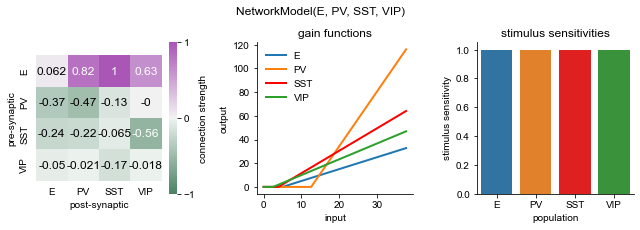

In [11]:
figs['model4'] = model4.plot_summary(norm=norm_params)

### Optimize model parameters and plot resulting predictions for different sets of constraints

 2025/09/17 15:10:16: initialized ModelOptimizer([E, PV, SST, VIP*], diffev, norm, xwdev=2.0)
 2025/09/17 15:10:16: ModelOptimizer([E, PV, SST, VIP*], diffev, norm, xwdev=2.0), relwmax = 0.3, variable srel, min VIP srel = 0.0
 2025/09/17 15:10:16: found 5 optimization log files in /Users/tlemaire/Documents/data/usnm/model
 2025/09/17 15:10:16: ModelOptimizer([E, PV, SST, VIP*], diffev, norm, xwdev=2.0): running 5 optimization runs
 2025/09/17 15:10:16: loading optimization results from /Users/tlemaire/Documents/data/usnm/model/E-PV-SST-VIP_threshold_linear_fparams43842d48abcb69b3833faa0d101c1bf6_tauE20.01PV5.93SST20.36VIP13.46_targetsf2821bbe470def2e47e4849c9edad8f4_wboundsed1f63fb4e07c38c9ee8b1bb2cc90d97_srelbounds0.0-5.0_diffev_norm_xwdev2_run0.h5
 2025/09/17 15:10:16: loading optimization results from /Users/tlemaire/Documents/data/usnm/model/E-PV-SST-VIP_threshold_linear_fparams43842d48abcb69b3833faa0d101c1bf6_tauE20.01PV5.93SST20.36VIP13.46_targetsf2821bbe470def2e47e4849c9edad8f4_

/Users/tlemaire/Documents/code/usnm2p/usnm2p/model_optimizer.py:950: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.stripplot(


0.2996939602206071
 2025/09/17 15:10:18: no activity detected in VIP population
 2025/09/17 15:10:19: ModelOptimizer([E, PV, SST, VIP*], diffev, norm, xwdev=2.0), relwmax = 0.3, variable srel, min VIP srel = 0.5
 2025/09/17 15:10:19: found 5 optimization log files in /Users/tlemaire/Documents/data/usnm/model
 2025/09/17 15:10:19: ModelOptimizer([E, PV, SST, VIP*], diffev, norm, xwdev=2.0): running 5 optimization runs
 2025/09/17 15:10:19: loading optimization results from /Users/tlemaire/Documents/data/usnm/model/E-PV-SST-VIP_threshold_linear_fparams43842d48abcb69b3833faa0d101c1bf6_tauE20.01PV5.93SST20.36VIP13.46_targetsf2821bbe470def2e47e4849c9edad8f4_wboundsed1f63fb4e07c38c9ee8b1bb2cc90d97_srelbounds58c0e20b406d480d04ebcb2c2ac86190_diffev_norm_xwdev2_run0.h5
 2025/09/17 15:10:19: loading optimization results from /Users/tlemaire/Documents/data/usnm/model/E-PV-SST-VIP_threshold_linear_fparams43842d48abcb69b3833faa0d101c1bf6_tauE20.01PV5.93SST20.36VIP13.46_targetsf2821bbe470def2e47e484

/Users/tlemaire/Documents/code/usnm2p/usnm2p/model_optimizer.py:950: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.stripplot(


0.29738649487662966
 2025/09/17 15:10:21: no activity detected in VIP population
 2025/09/17 15:10:21: ModelOptimizer([E, PV, SST, VIP*], diffev, norm, xwdev=2.0), relwmax = 0.3, variable srel, min VIP srel = 1.0
 2025/09/17 15:10:21: found 5 optimization log files in /Users/tlemaire/Documents/data/usnm/model
 2025/09/17 15:10:21: ModelOptimizer([E, PV, SST, VIP*], diffev, norm, xwdev=2.0): running 5 optimization runs
 2025/09/17 15:10:21: loading optimization results from /Users/tlemaire/Documents/data/usnm/model/E-PV-SST-VIP_threshold_linear_fparams43842d48abcb69b3833faa0d101c1bf6_tauE20.01PV5.93SST20.36VIP13.46_targetsf2821bbe470def2e47e4849c9edad8f4_wboundsed1f63fb4e07c38c9ee8b1bb2cc90d97_srelboundsc7352bf1a48b608ba92b119b1a544871_diffev_norm_xwdev2_run0.h5
 2025/09/17 15:10:21: loading optimization results from /Users/tlemaire/Documents/data/usnm/model/E-PV-SST-VIP_threshold_linear_fparams43842d48abcb69b3833faa0d101c1bf6_tauE20.01PV5.93SST20.36VIP13.46_targetsf2821bbe470def2e47e48

/Users/tlemaire/Documents/code/usnm2p/usnm2p/model_optimizer.py:950: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.stripplot(


0.299338778275096
 2025/09/17 15:10:23: no activity detected in VIP population
 2025/09/17 15:10:23: ModelOptimizer([E, PV, SST, VIP*], diffev, norm, xwdev=2.0), relwmax = 0.3, variable srel, min VIP srel = 1.5
 2025/09/17 15:10:23: found 5 optimization log files in /Users/tlemaire/Documents/data/usnm/model
 2025/09/17 15:10:23: ModelOptimizer([E, PV, SST, VIP*], diffev, norm, xwdev=2.0): running 5 optimization runs
 2025/09/17 15:10:23: loading optimization results from /Users/tlemaire/Documents/data/usnm/model/E-PV-SST-VIP_threshold_linear_fparams43842d48abcb69b3833faa0d101c1bf6_tauE20.01PV5.93SST20.36VIP13.46_targetsf2821bbe470def2e47e4849c9edad8f4_wboundsed1f63fb4e07c38c9ee8b1bb2cc90d97_srelboundsf7826067f9138ea521c9425606ee1b28_diffev_norm_xwdev2_run0.h5
 2025/09/17 15:10:23: loading optimization results from /Users/tlemaire/Documents/data/usnm/model/E-PV-SST-VIP_threshold_linear_fparams43842d48abcb69b3833faa0d101c1bf6_tauE20.01PV5.93SST20.36VIP13.46_targetsf2821bbe470def2e47e4849

/Users/tlemaire/Documents/code/usnm2p/usnm2p/model_optimizer.py:950: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.stripplot(


0.29928206764152615
 2025/09/17 15:10:25: ModelOptimizer([E, PV, SST, VIP*], diffev, norm, xwdev=2.0), relwmax = 0.3, variable srel, min VIP srel = 2.0
 2025/09/17 15:10:25: found 5 optimization log files in /Users/tlemaire/Documents/data/usnm/model
 2025/09/17 15:10:25: ModelOptimizer([E, PV, SST, VIP*], diffev, norm, xwdev=2.0): running 5 optimization runs
 2025/09/17 15:10:25: loading optimization results from /Users/tlemaire/Documents/data/usnm/model/E-PV-SST-VIP_threshold_linear_fparams43842d48abcb69b3833faa0d101c1bf6_tauE20.01PV5.93SST20.36VIP13.46_targetsf2821bbe470def2e47e4849c9edad8f4_wboundsed1f63fb4e07c38c9ee8b1bb2cc90d97_srelbounds364b3514f3e15ee4a009e4cfbd14b039_diffev_norm_xwdev2_run0.h5
 2025/09/17 15:10:25: loading optimization results from /Users/tlemaire/Documents/data/usnm/model/E-PV-SST-VIP_threshold_linear_fparams43842d48abcb69b3833faa0d101c1bf6_tauE20.01PV5.93SST20.36VIP13.46_targetsf2821bbe470def2e47e4849c9edad8f4_wboundsed1f63fb4e07c38c9ee8b1bb2cc90d97_srelbound

/Users/tlemaire/Documents/code/usnm2p/usnm2p/model_optimizer.py:950: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.stripplot(


0.299940199035504
 2025/09/17 15:10:27: ModelOptimizer([E, PV, SST, VIP*], diffev, norm, xwdev=2.0), relwmax = 0.3, variable srel, min VIP srel = 3.0
 2025/09/17 15:10:27: found 5 optimization log files in /Users/tlemaire/Documents/data/usnm/model
 2025/09/17 15:10:27: ModelOptimizer([E, PV, SST, VIP*], diffev, norm, xwdev=2.0): running 5 optimization runs
 2025/09/17 15:10:27: loading optimization results from /Users/tlemaire/Documents/data/usnm/model/E-PV-SST-VIP_threshold_linear_fparams43842d48abcb69b3833faa0d101c1bf6_tauE20.01PV5.93SST20.36VIP13.46_targetsf2821bbe470def2e47e4849c9edad8f4_wboundsed1f63fb4e07c38c9ee8b1bb2cc90d97_srelboundsd67cbc67816e3df7e9ac6cd9ec82de26_diffev_norm_xwdev2_run0.h5
 2025/09/17 15:10:27: loading optimization results from /Users/tlemaire/Documents/data/usnm/model/E-PV-SST-VIP_threshold_linear_fparams43842d48abcb69b3833faa0d101c1bf6_tauE20.01PV5.93SST20.36VIP13.46_targetsf2821bbe470def2e47e4849c9edad8f4_wboundsed1f63fb4e07c38c9ee8b1bb2cc90d97_srelboundsd

/Users/tlemaire/Documents/code/usnm2p/usnm2p/model_optimizer.py:950: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.stripplot(


0.2989633458138163
 2025/09/17 15:10:29: ModelOptimizer([E, PV, SST, VIP*], diffev, norm, xwdev=2.0), relwmax = 0.3, variable srel, min VIP srel = 4.0
 2025/09/17 15:10:29: found 5 optimization log files in /Users/tlemaire/Documents/data/usnm/model
 2025/09/17 15:10:29: ModelOptimizer([E, PV, SST, VIP*], diffev, norm, xwdev=2.0): running 5 optimization runs
 2025/09/17 15:10:29: loading optimization results from /Users/tlemaire/Documents/data/usnm/model/E-PV-SST-VIP_threshold_linear_fparams43842d48abcb69b3833faa0d101c1bf6_tauE20.01PV5.93SST20.36VIP13.46_targetsf2821bbe470def2e47e4849c9edad8f4_wboundsed1f63fb4e07c38c9ee8b1bb2cc90d97_srelboundsa202559ddc9a2ae749a0d7e65e57e769_diffev_norm_xwdev2_run0.h5
 2025/09/17 15:10:29: loading optimization results from /Users/tlemaire/Documents/data/usnm/model/E-PV-SST-VIP_threshold_linear_fparams43842d48abcb69b3833faa0d101c1bf6_tauE20.01PV5.93SST20.36VIP13.46_targetsf2821bbe470def2e47e4849c9edad8f4_wboundsed1f63fb4e07c38c9ee8b1bb2cc90d97_srelbounds

/Users/tlemaire/Documents/code/usnm2p/usnm2p/model_optimizer.py:950: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.stripplot(


0.2989281329846358


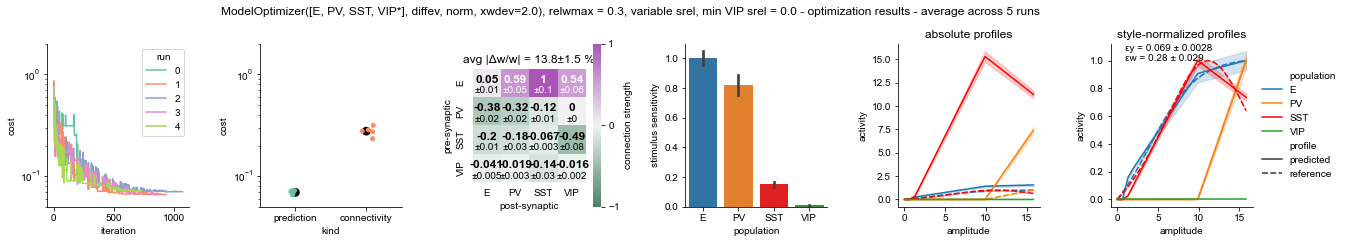

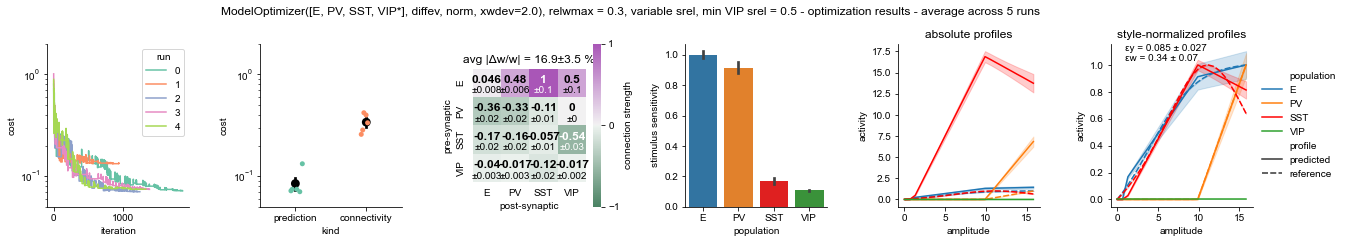

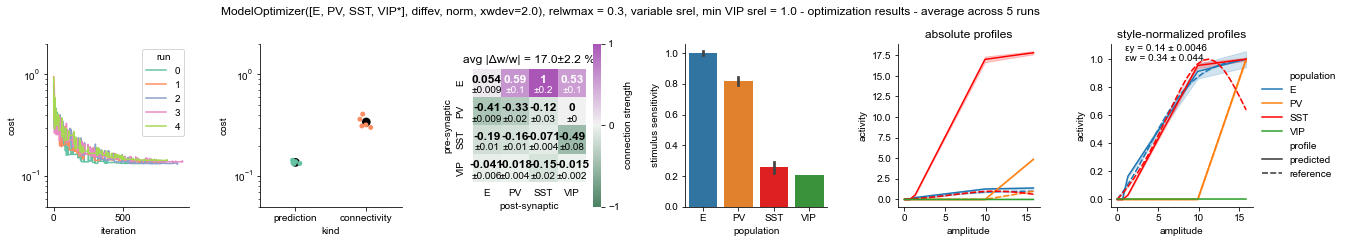

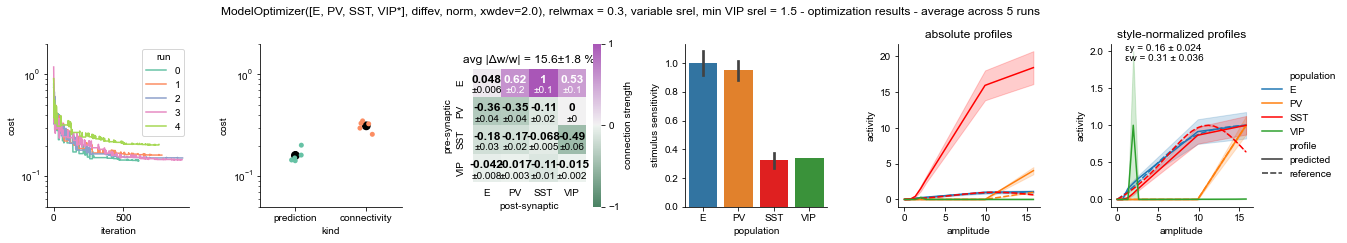

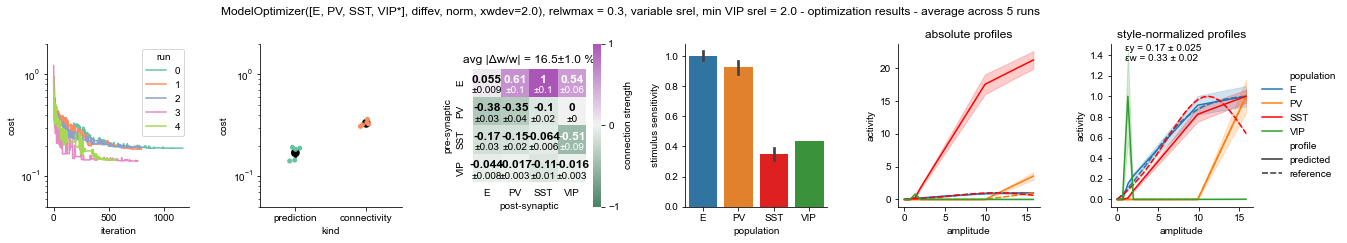

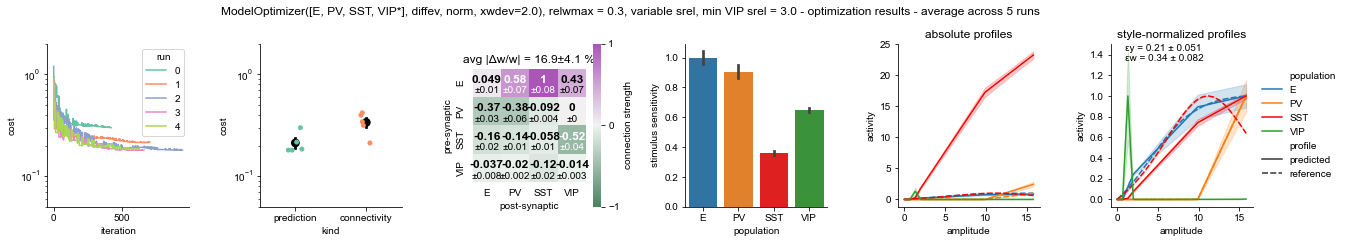

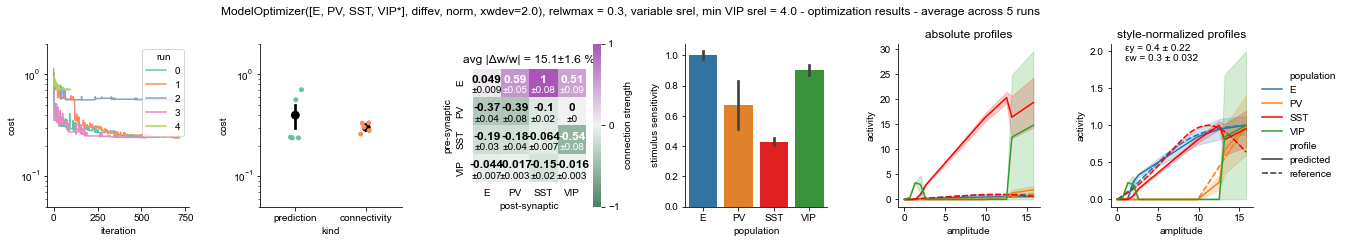

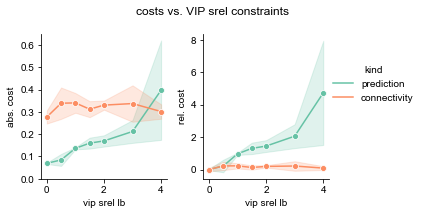

In [12]:
# Construct model optimizer object
optimizer = ModelOptimizer(model4, ref_profiles)

# Define connectivity matrix exploration bounds 
Wbounds, Wkey = optimizer.model.get_coupling_bounds(relwmax=RELWMAX, return_key=True)

# Define uniformity/heterogeneity of stimulus sensitivities
srel_key, uniform_srel = ('variable', False)

# For different VIP sensitivity lower bounds 
vip_min_srels = [0., 0.5, 1., 1.5, 2., 3., 4.]
costs_vs_vip_srel = {}
for vip_min_srel in vip_min_srels:
    # Construct descriptor string
    desc = f'{optimizer}, {Wkey}, {srel_key} srel'
    if vip_min_srel is not None:
        desc = f'{desc}, min VIP srel = {vip_min_srel}'
    logger.info(desc)

    # Define stimulus sensitivity exploration bounds
    if vip_min_srel == 0.:
        srel_bounds = (0, SRELMAX)
    else:
        srel_bounds = pd.Series({k: (float(vip_min_srel), 5.) if k == 'VIP' else (0., SRELMAX) for k in optimizer.model.keys})

    # Optimize model parameters to minimize divergence with reference profiles
    optparams = optimizer.optimize(
        logdir=logdir, 
        Wbounds=Wbounds,
        srel_bounds=srel_bounds,
        uniform_srel=uniform_srel,
        nruns='auto'
    )

    # Plot optimization history
    opt_history = optimizer.load_optimization_histories(
        logdir, Wbounds, srel_bounds, uniform_srel)

    # Plot optimized model parameters and simulated sweep results, compared to reference profiles
    title = f'{desc} - optimization results'
    figs[title], costs = optimizer.plot_results(
        mparams=optparams, opt_history=opt_history, norm_params=norm_params, norm_res=norm_res, title=title, 
        avg_across_runs=avg_across_runs, return_costs=True, height=3)
    
    # Store costs in dictionary
    costs_vs_vip_srel[vip_min_srel] = costs

    # # Compute and plot breakdown of drive contributions
    # title = f'{desc} - drive contributions'
    # figs[title] = optimizer.model.plot_drive_contributions(
    #     optimizer.compute_drive_contributions(optparams), title=title)

    # # Compute and plot relative change in connectivity matrix
    # Wreldev = pd.concat(
    #     {k: optimizer.get_relative_change(optimizer.model.parse_input_vector(v)[0], optimizer.Wref) for k, v in optparams.iterrows()},
    #     axis=0, names=['run'])
    # title = f'{desc} - relative W deviation'
    # figs[title] = model.plot_connectivity_matrix(
    #     Wreldev * 100,
    #     agg=avg_across_runs,
    #     clabel='err (%)',
    #     title=title,
    #     colwrap=len(optparams) if avg_across_runs else None,
    #     # height=10
    # )
    # if not avg_across_runs:
    #     figs[title].subplots_adjust(bottom=0.4)

# Convert cost dictionary into dataframe
costs_vs_vip_srel = pd.concat(costs_vs_vip_srel, names=['vip srel lb'])

# Compute relative costs variations
costs0 = costs_vs_vip_srel.loc[0].mean()
rel_costs_vs_vip_srel = ((costs_vs_vip_srel - costs0) / costs0)

# Plot absolute and relative variations in costs vs VIP srel lower bound
all_costs_vs_vip_srel = {
    'abs. cost': costs_vs_vip_srel,
    'rel. cost': rel_costs_vs_vip_srel
}
title = 'costs vs. VIP srel constraints'
figs[title], axes = plt.subplots(1, len(all_costs_vs_vip_srel), figsize=(3 * len(all_costs_vs_vip_srel), 3))
figs[title].suptitle(title)
for ax, (k, costdf) in zip(axes, all_costs_vs_vip_srel.items()):
    sns.despine(ax=ax)
    sns.lineplot(
        ax=ax,
        data=costdf.stack().rename(k).reset_index(),
        x='vip srel lb',
        y=k,
        hue='kind',
        palette='Set2',
        errorbar='sd',
        marker='o',
        legend=ax is axes[-1]
    )
    if 'abs' in k:
        ax.set_ylim(0, ax.get_ylim()[1])
sns.move_legend(ax, (1, 0.5), frameon=False)
figs[title].tight_layout()

### Save figures

In [13]:
figs = {k: v for k, v in figs.items() if v is not None}
save_figs_book(figsdir, figs, suffix='network_model')

 2025/09/17 15:10:36: saving figures in /Users/tlemaire/Documents/data/usnm/figs/2025.09.17/figs_network_model.pdf:


100%|██████████| 20/20 [00:07<00:00,  2.59it/s]


### Notify upon completion

In [14]:
# Get time stamp from notebook completion
tstamp_end = datetime.datetime.now()

# Log completion process
s = f'circuit model analysis notebook completed in {tstamp_end - tstamp_start} s'
if slack_notify:
    jupyter_slack.notify_self(s)
logger.info(s)

 2025/09/17 15:10:45: circuit model analysis notebook completed in 0:00:46.185197 s
